In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
import json 

c:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\singhy\AppData\Local\Temp\ipykernel_27444\4161930417.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:

# Specify directories 
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"
temp_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/temp"

# Wage Analysis

In [124]:
wage_data = pd.read_excel(f"{data_dir}/atl_fed/wage-growth-data.xlsx", sheet_name = "Industry", skiprows=2, header=0)
cpi = pd.read_csv(f"{data_dir}/CPI/CPIAUCSL.csv")

In [125]:
# CPI-U 
cpi = cpi.iloc[10:].reset_index(drop=True)

cpi = cpi.rename(columns={
                            'observation_date': 'date', 
                            'CPIAUCSL':               'P'
})

cpi['date'] = pd.to_datetime(cpi['date'])
cpi['P'] = pd.to_numeric(cpi['P'], errors='coerce')
cpi['P_12m_change'] = cpi['P'].pct_change(periods=12) * 100


wage_data = wage_data.rename(columns =
                   {'Unnamed: 0' : 'date'})
wage_data = wage_data.merge(cpi, on='date', how = 'left')

In [126]:
wage_data = wage_data[wage_data['date'] >= '2015-12-01']
wage_data = wage_data[wage_data['date'] <= '2024-12-01']

In [127]:

wage_data['wage_index_Construction and mining'] = 1
wage_data['wage_index_Education and health'] = 1
wage_data['wage_index_Finance and business services'] = 1
wage_data['wage_index_Leisure and hospitality and other services'] = 1
wage_data['wage_index_Manufacturing'] = 1
wage_data['wage_index_Public administration'] = 1
wage_data['wage_index_Trade and transportation'] = 1
wage_data['med_wage_index'] = 1 

#wage_data['P_norm'] = wage_data['P'] / wage_data['P'].iloc[0]
#wage_data['price_mom_grth'] = 1 + wage_data['P_norm'].pct_change()

wage_data = wage_data[wage_data['date'] >= '2016-01-01']

wage_data['Construction and mining_mom_grth'] = 1+ (wage_data['Construction and mining']/100)/12
wage_data['Education and health_mom_grth'] = 1+ (wage_data['Education and health']/100)/12
wage_data['Finance and business services_mom_grth'] = 1+ (wage_data['Finance and business services']/100)/12
wage_data['Leisure and hospitality and other services_mom_grth'] = 1+ (wage_data['Leisure and hospitality and other services']/100)/12
wage_data['Manufacturing_mom_grth'] = 1+ (wage_data['Manufacturing']/100)/12
wage_data['Public administration_mom_grth'] = 1+ (wage_data['Public administration']/100)/12
wage_data['Trade and transportation_mom_grth'] = 1+ (wage_data['Trade and transportation']/100)/12

wage_data['med_mom_grth'] = 1+ (wage_data['Overall']/100)/12

wage_data['P_1m_change'] = 1 + (wage_data['P_12m_change']/100)/12

wage_data['nom_wage_index_Construction and mining'] = wage_data['Construction and mining_mom_grth'].cumprod()
wage_data['nom_wage_index_Education and health'] = wage_data['Education and health_mom_grth'].cumprod()
wage_data['nom_wage_index_Finance and business services'] = wage_data['Finance and business services_mom_grth'].cumprod()
wage_data['nom_wage_index_Leisure and hospitality and other services'] = wage_data['Leisure and hospitality and other services_mom_grth'].cumprod()
wage_data['nom_wage_index_Manufacturing'] = wage_data['Manufacturing_mom_grth'].cumprod()
wage_data['nom_wage_index_Public administration'] = wage_data['Public administration_mom_grth'].cumprod()
wage_data['nom_wage_index_Trade and transportation'] = wage_data['Trade and transportation_mom_grth'].cumprod()
wage_data['med_nom_wage_index'] = wage_data['med_mom_grth'].cumprod()
wage_data['price_index']      = wage_data['P_1m_change'].cumprod()





#wage_data['cpi']              = wage_data['price_mom_grth'].cumprod()



wage_data = wage_data.fillna(1)

wage_data['real_wage_index_Construction and mining'] = wage_data['nom_wage_index_Construction and mining'] / wage_data['price_index']
wage_data['real_wage_index_Education and health'] = wage_data['nom_wage_index_Education and health'] / wage_data['price_index']
wage_data['real_wage_index_Finance and business services'] = wage_data['nom_wage_index_Finance and business services'] / wage_data['price_index']
wage_data['real_wage_index_Leisure and hospitality and other services'] = wage_data['nom_wage_index_Leisure and hospitality and other services'] / wage_data['price_index']

wage_data['real_wage_index_Manufacturing'] = wage_data['nom_wage_index_Manufacturing'] / wage_data['price_index']
wage_data['real_wage_index_Public administration'] = wage_data['nom_wage_index_Public administration'] / wage_data['price_index']
wage_data['real_wage_index_Trade and transportation'] = wage_data['nom_wage_index_Trade and transportation'] / wage_data['price_index']

wage_data['med_real_wage_index'] = wage_data['med_nom_wage_index'] / wage_data['price_index']


# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression with months since the start date
X = ((trend_data['date'].dt.year - trend_data['date'].min().year) * 12 +
     (trend_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)

# Create a dictionary to hold the predicted values for each wage index
predicted_values = {}

# Loop through each wage index to predict values
for column_name in [
       'real_wage_index_Construction and mining',
       'real_wage_index_Education and health',
       'real_wage_index_Finance and business services',
       'real_wage_index_Leisure and hospitality and other services',
       'real_wage_index_Manufacturing', 'real_wage_index_Public administration',
       'real_wage_index_Trade and transportation', 'med_real_wage_index',
       'price_index']:
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for the entire dataset, using months since the start date
    all_dates = ((wage_data['date'].dt.year - trend_data['date'].min().year) * 12 +
                 (wage_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)
    predicted_values[column_name] = model.predict(all_dates)

# Add the predicted columns to the DataFrame
for column_name in predicted_values:
    wage_data[f'predicted_{column_name}'] = predicted_values[column_name]

C:\Users\singhy\AppData\Local\Temp\ipykernel_28840\168763208.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wage_data = wage_data.fillna(1)


In [136]:
gaps = {
    'gap_Construction and Mining': wage_data['predicted_real_wage_index_Construction and mining'].iloc[-1] - wage_data['real_wage_index_Construction and mining'].iloc[-1],
    'gap_Education and health': wage_data['predicted_real_wage_index_Education and health'].iloc[-1] - wage_data['real_wage_index_Education and health'].iloc[-1],
    'gap_Leisure and hospitality and other services': wage_data['predicted_real_wage_index_Leisure and hospitality and other services'].iloc[-1] - wage_data['real_wage_index_Leisure and hospitality and other services'].iloc[-1],
    'gap_Manufacturing': wage_data['predicted_real_wage_index_Manufacturing'].iloc[-1] - wage_data['real_wage_index_Manufacturing'].iloc[-1],
    'gap_Public administration': wage_data['predicted_real_wage_index_Public administration'].iloc[-1] - wage_data['real_wage_index_Public administration'].iloc[-1],
    'gap_Trade and transportation': wage_data['predicted_real_wage_index_Trade and transportation'].iloc[-1] - wage_data['real_wage_index_Trade and transportation'].iloc[-1],
    'gap_Finance and business Services': wage_data['predicted_real_wage_index_Finance and business services'].iloc[-1] - wage_data['real_wage_index_Finance and business services'].iloc[-1], 
    'gap_med': wage_data['predicted_med_real_wage_index'].iloc[-1] - wage_data['med_real_wage_index'].iloc[-1],
}


In [137]:
gaps

{'gap_Construction and Mining': 0.010766840214888385,
 'gap_Education and health': 0.04235475197178995,
 'gap_Leisure and hospitality and other services': 0.026991202182023333,
 'gap_Manufacturing': 0.04468440702117005,
 'gap_Public administration': 0.03785184179616974,
 'gap_Trade and transportation': 0.04214511713217983,
 'gap_Finance and business Services': 0.03406313958276286,
 'gap_med': 0.03829042504756974}

# Flow Analysis 

In [3]:
# Load the re-uploaded Excel file

df_raw = pd.read_excel(f"{data_dir}/JOLTS/jolts_flows.xlsx", skiprows=2)

# Extract header and reformat
new_header = df_raw.iloc[0]
df_clean = df_raw[1:]
df_clean.columns = new_header
df_clean = df_clean.rename(columns={df_clean.columns[0]: "seriesid"})
df_clean.columns = df_clean.columns.astype(str)

# Reshape and clean
df_long = df_clean.melt(id_vars=["seriesid"], var_name="date", value_name="value")
df_long["date"] = df_long["date"].str.replace("\n", " ").str.strip()
df_long["date"] = pd.to_datetime(df_long["date"], format="%b %Y", errors="coerce")
df_long = df_long.dropna(subset=["date", "value"])
df_long = df_long.sort_values(by=["seriesid", "date"]).reset_index(drop=True)

# Extract codes from seriesid
df_long["industry_code"] = df_long["seriesid"].str[3:11]
df_long["flow_type_code"] = df_long["seriesid"].str[-3:]

# Get unique codes
industry_codes = df_long["industry_code"].unique()
flow_type_codes = df_long["flow_type_code"].unique()

industry_codes, flow_type_codes

# Define flow type mapping
flow_type_map = {
    "HIR": "Hires",
    "QUR": "Quits",
    "TSR": "Total Separations",
    "JOR": "Job Openings",
    "LDR": "Layoffs & Discharges",
    "UOR": "Other Separations",
    "OSR": "Other Separations (Residual)"
}

# Define industry code mapping based on BLS JOLTS industry categories
industry_map = {
    "00000000": "Total nonfarm",
    "10000000": "Total private",
    "11009900": "Mining and logging",
    "23000000": "Construction",
    "30000000": "Manufacturing",
    "32000000": "Durable goods manufacturing",
    "34000000": "Nondurable goods manufacturing",
    "40000000": "Trade, transportation, and utilities",
    "42000000": "Wholesale trade",
    "44000000": "Retail trade",
    "48009900": "Transportation, warehousing, and utilities",
    "51000000": "Information",
    "51009900": "Information (detailed)",
    "52000000": "Financial activities",
    "53000000": "Finance and insurance",
    "54009900": "Real estate and rental and leasing",
    "60000000": "Professional and business services",
    "61000000": "Professional, scientific, and technical services",
    "62000000": "Administrative and support and waste management",
    "70000000": "Education and health services",
    "71000000": "Educational services",
    "72000000": "Health care and social assistance",
    "81000000": "Leisure and hospitality",
    "90000000": "Other services",
    "91000000": "Federal government",
    "92000000": "State and local government",
    "92300000": "State government",
    "92900000": "Local government"
}

# Apply mappings
df_long["flow_type"] = df_long["flow_type_code"].map(flow_type_map)
df_long["industry"] = df_long["industry_code"].map(industry_map)

df_long = df_long.rename(columns={
    'value': 'rate',
})



c:\Users\singhy\AppData\Local\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [4]:
df_long

,seriesid,date,rate,industry_code,flow_type_code,flow_type,industry
0,JTS000000000000000HIR,2016-01-01,3.6,00000000,HIR,Hires,Total nonfarm
1,JTS000000000000000HIR,2016-02-01,3.8,00000000,HIR,Hires,Total nonfarm
2,JTS000000000000000HIR,2016-03-01,3.7,00000000,HIR,Hires,Total nonfarm
3,JTS000000000000000HIR,2016-04-01,3.7,00000000,HIR,Hires,Total nonfarm
4,JTS000000000000000HIR,2016-05-01,3.6,00000000,HIR,Hires,Total nonfarm
...,...,...,...,...,...,...,...
18247,JTS929000000000000TSR,2024-08-01,1.5,92900000,TSR,Total Separations,Local government
18248,JTS929000000000000TSR,2024-09-01,1.5,92900000,TSR,Total Separations,Local government
18249,JTS929000000000000TSR,2024-10-01,1.3,92900000,TSR,Total Separations,Local government
18250,JTS929000000000000TSR,2024-11-01,1.5,92900000,TSR,Total Separations,Local government


In [104]:
keep = ['date', 'rate', 'flow_type', 'industry']
data = df_long[keep]

In [105]:
keep_list = [
    'Mining and logging', 'Construction',
    'Wholesale trade',
    'Retail trade',
    'Education and health services', 'Educational services', 'Health care and social assistance',
    'Leisure and hospitality', 'Other services',
    'Trade, transportation, and utilities', 'Transportation, warehousing, and utilities',
    'Manufacturing',
    'Information', 'Information (detailed)', 'Financial activities', 'Finance and insurance',
    'Real estate and rental and leasing', 'Professional and business services',
    'Professional, scientific, and technical services', 'Administrative and support and waste management', 
     "Federal government", "State and local government", "State government", "Local government"
]

In [106]:
data = data[data['industry'].isin(keep_list)]

In [108]:
jolts_to_wage_mapping = {
    'Mining and logging': 'Construction and Mining',
    'Construction': 'Construction and Mining',

    'Education and health services': 'Education and health',
    'Educational services': 'Education and health',
    'Health care and social assistance': 'Education and health',

    'Leisure and hospitality': 'Leisure and hospitality and other services',
    'Other services': 'Leisure and hospitality and other services',

    'Trade, transportation, and utilities': 'Trade and transportation',
    'Transportation, warehousing, and utilities': 'Trade and transportation',
    'Wholesale trade': 'Trade and transportation',
    'Retail trade': 'Trade and transportation',

    'Manufacturing': 'Manufacturing',

    'Information': 'Finance and business services',
    'Information (detailed)': 'Finance and business services',
    'Financial activities': 'Finance and business services',
    'Finance and insurance': 'Finance and business services',
    'Real estate and rental and leasing': 'Finance and business services',
    'Professional and business services': 'Finance and business services',
    'Professional, scientific, and technical services': 'Finance and business services',
    'Administrative and support and waste management': 'Finance and business services', 
    
    "Federal government" : "Public Administration", 
    "State and local government" : "Public Administration", 
    "State government" : "Public Administration", 
    "Local government" : "Public Administration", 
}


In [109]:
data['agg_ind'] = data['industry'].map(jolts_to_wage_mapping)


In [110]:
data = data.groupby(['agg_ind', 'flow_type', 'date'])['rate'].mean().reset_index()
data = data[data['date'].dt.year != 2020]

In [ ]:
data['fl']

,agg_ind,flow_type,date,rate
0,Construction and Mining,Hires,2016-01-01,3.85
1,Construction and Mining,Hires,2016-02-01,4.15
2,Construction and Mining,Hires,2016-03-01,4.5
3,Construction and Mining,Hires,2016-04-01,4.0
4,Construction and Mining,Hires,2016-05-01,3.9
...,...,...,...,...
4531,Trade and transportation,Total Separations,2024-08-01,3.2
4532,Trade and transportation,Total Separations,2024-09-01,3.2
4533,Trade and transportation,Total Separations,2024-10-01,3.5
4534,Trade and transportation,Total Separations,2024-11-01,3.45


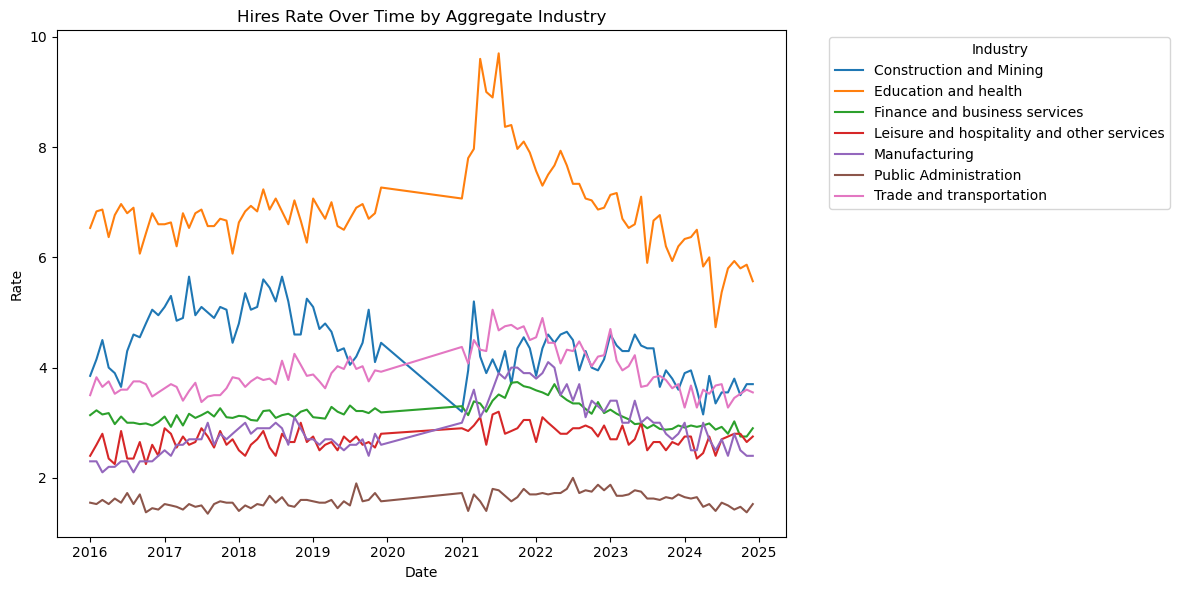

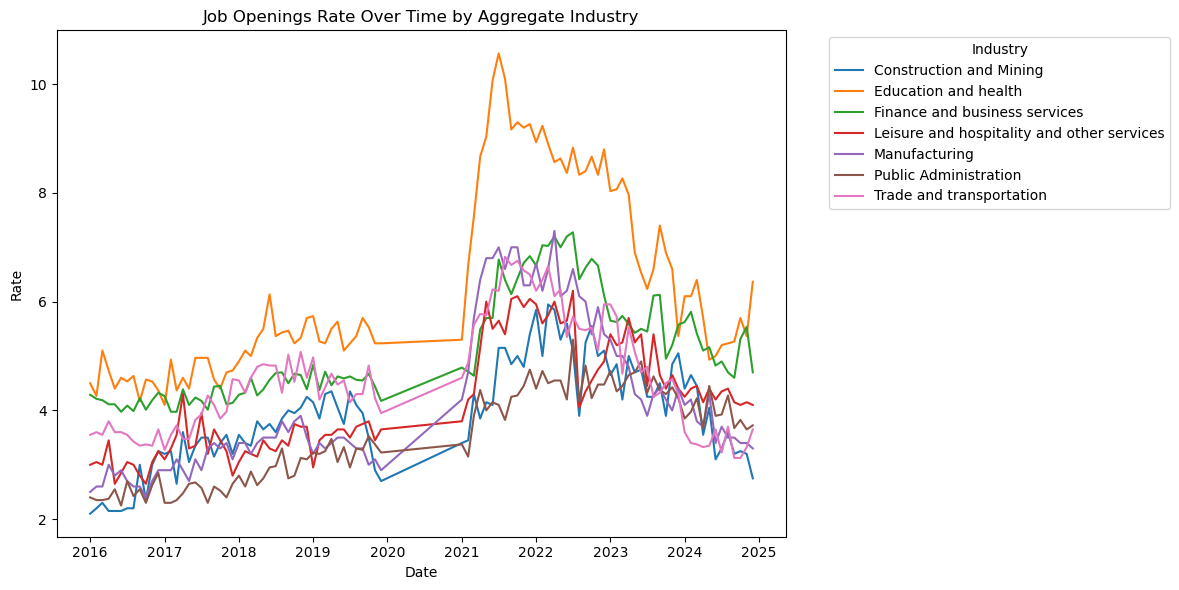

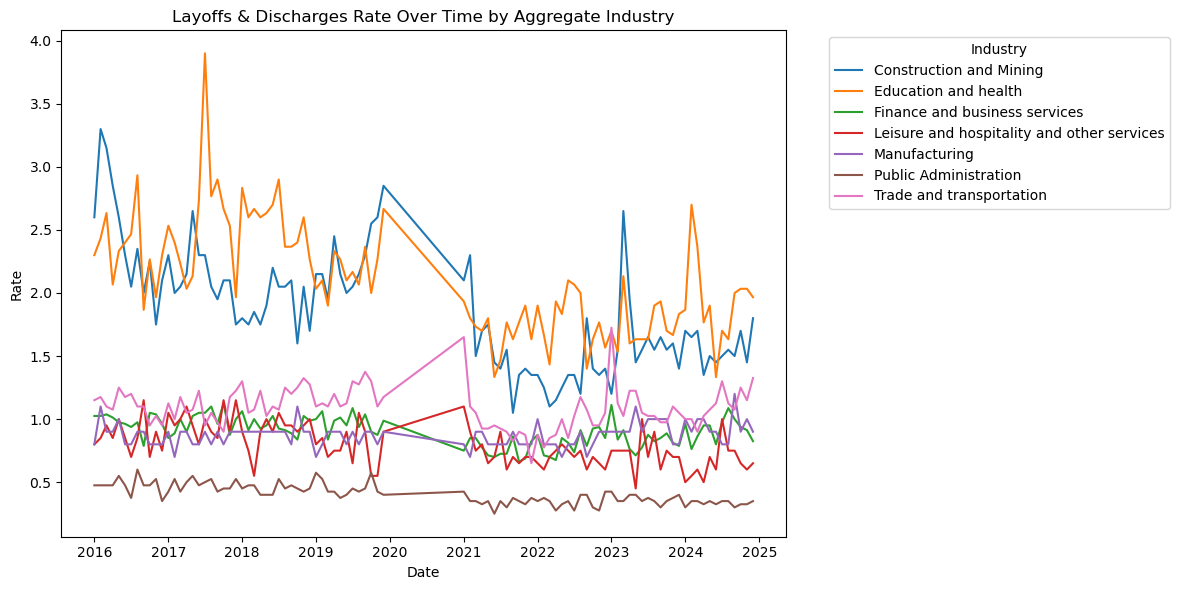

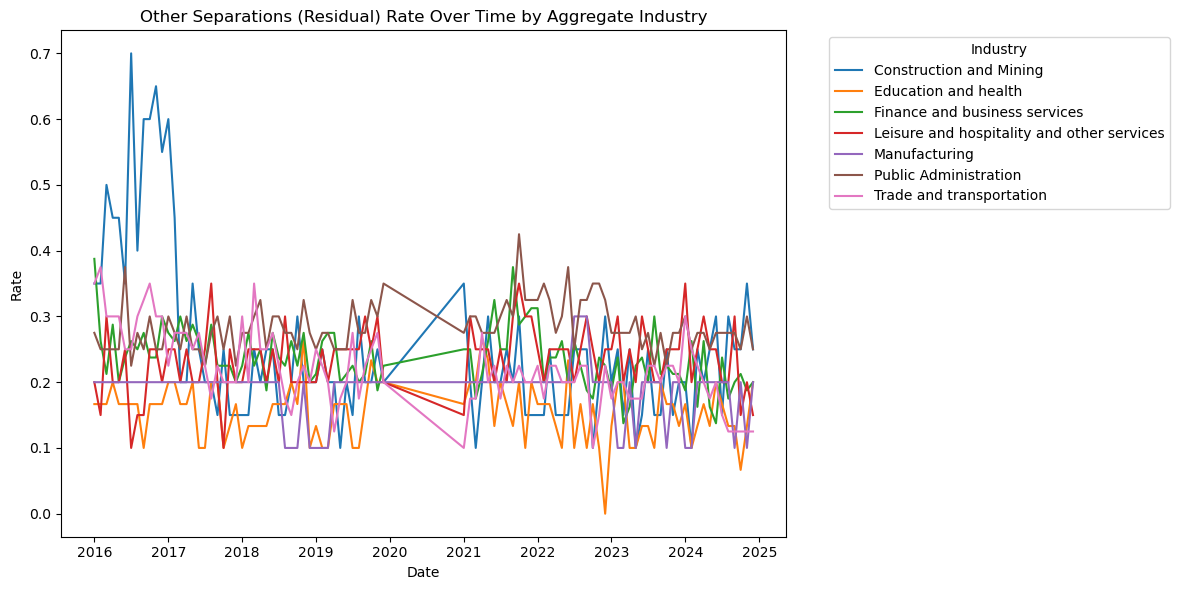

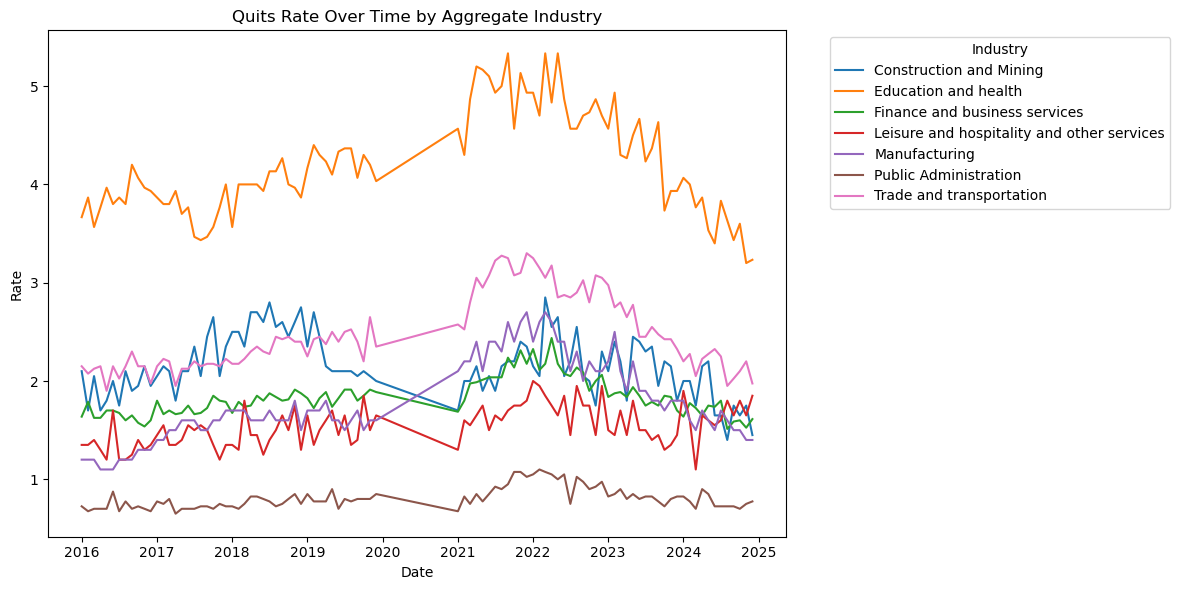

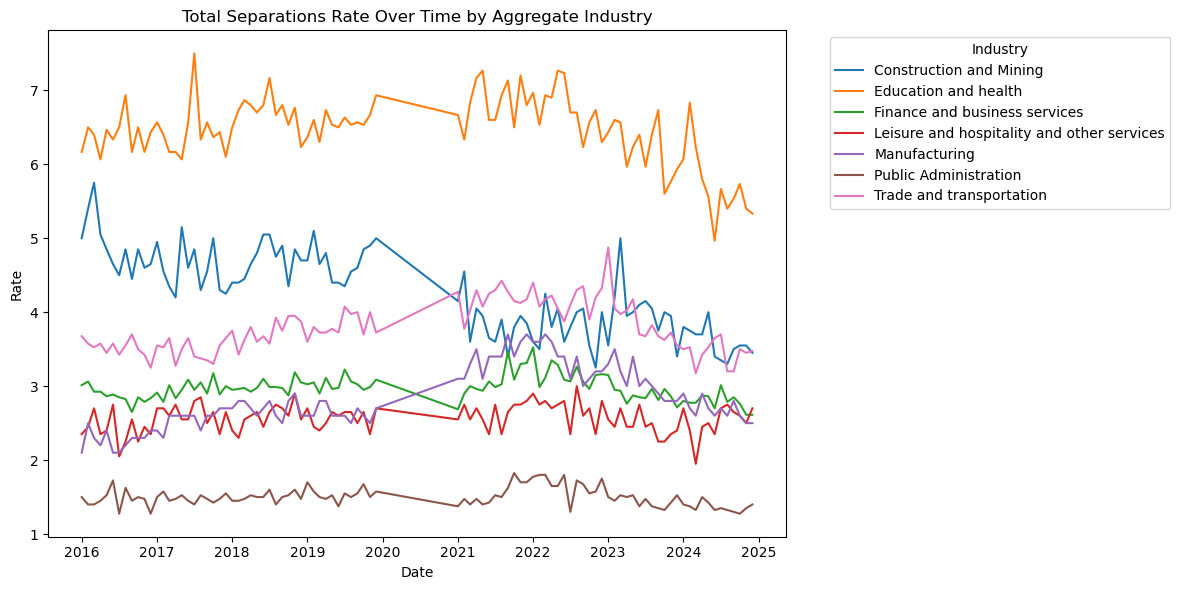

In [112]:
# Convert date column to datetime
data['date'] = pd.to_datetime(data['date'])

# Group by date, agg_ind, and flow_type, then calculate mean rate
ts_df = data.groupby(['date', 'agg_ind', 'flow_type'])['rate'].mean().reset_index()

# Plot time series for each flow type
flow_types = ts_df['flow_type'].unique()

import matplotlib.pyplot as plt

for flow in flow_types:
    subset = ts_df[ts_df['flow_type'] == flow]
    plt.figure(figsize=(12, 6))
    for industry in subset['agg_ind'].unique():
        industry_data = subset[subset['agg_ind'] == industry]
        plt.plot(industry_data['date'], industry_data['rate'], label=industry)
    
    plt.title(f'{flow} Rate Over Time by Aggregate Industry')
    plt.xlabel('Date')
    plt.ylabel('Rate')
    plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [114]:
conditions = [
    data['date'] < '2020-01-01',
    (data['date'] >= '2021-04-01') & (data['date'] <= '2023-05-01'),
    data['date'] >= '2023-06-01'
]
choices = ['pre', 'inf', 'post']

data['period'] = np.select(conditions, choices, default=pd.NA)

In [115]:
table = data.groupby(['agg_ind', 'flow_type', 'period'])['rate'].mean().reset_index()

In [116]:
table = table[table['period'] != 'post']

In [117]:

table = table.pivot_table(index=['agg_ind', 'flow_type'], columns='period', values='rate').reset_index()

table['pct_change'] = ((table['inf'] - table['pre']) / table['pre']) * 100

In [118]:
table = table.sort_values(by='flow_type').reset_index(drop = True)

In [119]:
table

period,agg_ind,flow_type,inf,pre,pct_change
0,Construction and Mining,Hires,4.267308,4.764583,-10.436918
1,Manufacturing,Hires,3.569231,2.610417,36.730309
2,Finance and business services,Hires,3.389904,3.123438,8.531189
3,Public Administration,Hires,1.727885,1.544792,11.852274
4,Education and health,Hires,7.701282,6.724306,14.529032
5,Leisure and hospitality and other services,Hires,2.882692,2.623958,9.860445
6,Trade and transportation,Hires,4.425962,3.749479,18.042036
7,Education and health,Job Openings,8.792308,4.986806,76.31142
8,Leisure and hospitality and other services,Job Openings,5.459615,3.338542,63.532941
9,Trade and transportation,Job Openings,5.939423,4.120833,44.131601


In [120]:
# Pivot the sorted DataFrame to create a matrix of pct_change values
pct_change_matrix = table.pivot(index='agg_ind', columns='flow_type', values='pct_change')




In [121]:
selected_columns = ['Hires', 'Job Openings', 'Layoffs & Discharges', 'Quits']
pct_change_selected = pct_change_matrix[selected_columns]

In [122]:
pct_change_selected

flow_type,Hires,Job Openings,Layoffs & Discharges,Quits
agg_ind,,,,
Construction and Mining,-10.436918,49.566223,-33.721058,-0.684882
Education and health,14.529032,76.31142,-28.520574,22.644543
Finance and business services,8.531189,47.064056,-17.88837,18.047601
Leisure and hospitality and other services,9.860445,63.532941,-21.003819,18.02625
Manufacturing,36.730309,94.389859,-2.834008,55.209887
Public Administration,11.852274,59.833867,-25.368249,25.074373
Trade and transportation,18.042036,44.131601,-13.271344,33.722337


In [138]:
# Create updated DataFrame
wage_gap_df_final = pd.DataFrame.from_dict(gaps, orient='index', columns=['real_wage_gap'])
wage_gap_df_final.index = wage_gap_df_final.index.str.replace('gap_', '', regex=False).str.lower()

# Rejoin with the lower-cased index table
pct_change_with_gap_final = pct_change_selected.copy()
pct_change_with_gap_final.index = pct_change_with_gap_final.index.str.lower()
pct_change_with_gap_final = pct_change_with_gap_final.join(wage_gap_df_final, how='left')

# Capitalize for final display
pct_change_with_gap_final.index.name = 'agg_ind'
pct_change_with_gap_final = pct_change_with_gap_final.reset_index()
pct_change_with_gap_final['agg_ind'] = pct_change_with_gap_final['agg_ind'].str.title()
pct_change_with_gap_final = pct_change_with_gap_final.set_index('agg_ind')

In [140]:
pct_change_with_gap_final['real_wage_gap']  = -pct_change_with_gap_final['real_wage_gap'] * 100

In [142]:

pct_change_with_gap_final.to_excel(f"{output_dir}/structural_change.xlsx")

In [100]:
pct_change_matrix.columns 'Hires', 'Job Openings', 'Layoffs & Discharges', 'Quits'

Index(['Hires', 'Job Openings', 'Layoffs & Discharges',
       'Other Separations (Residual)', 'Quits', 'Total Separations'],
      dtype='object', name='flow_type')

In [55]:
conditions = [
    data['date'] < '2020-01-01',
    (data['date'] >= '2021-04-01') & (data['date'] <= '2023-05-01'),
    data['date'] >= '2023-06-01'
]
choices = ['pre', 'inf', 'post']

data['period'] = np.select(conditions, choices, default=pd.NA)

In [59]:
data

,date,rate,flow_type,industry,agg_ind,period
1404,2016-01-01,3.2,Hires,Mining and logging,Construction and Mining,pre
1405,2016-02-01,2.9,Hires,Mining and logging,Construction and Mining,pre
1406,2016-03-01,3.6,Hires,Mining and logging,Construction and Mining,pre
1407,2016-04-01,2.7,Hires,Mining and logging,Construction and Mining,pre
1408,2016-05-01,3,Hires,Mining and logging,Construction and Mining,pre
...,...,...,...,...,...,...
15655,2024-08-01,1.4,Total Separations,Other services,Leisure and hospitality and other services,post
15656,2024-09-01,1.4,Total Separations,Other services,Leisure and hospitality and other services,post
15657,2024-10-01,1.3,Total Separations,Other services,Leisure and hospitality and other services,post
15658,2024-11-01,1.4,Total Separations,Other services,Leisure and hospitality and other services,post


In [58]:
data.to_csv(f"{temp_dir}/jolts_clean.csv")

# Employment/Output Shares 

In [ ]:
C:\Users\singhy\Desktop\Chicago\cps_data\inflation\scripts\structural_change